In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize images
x_train = x_train / 255.0
x_test = x_test / 255.0

# Only keep images from the first class for simplicity
x_train = x_train[y_train.flatten() == 0]
y_train = y_train[y_train.flatten() == 0]
x_test = x_test[y_test.flatten() == 0]
y_test = y_test[y_test.flatten() == 0]

num_samples = len(x_train)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [11]:
def create_object_detection_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)

    # Output layers
    bbox_predictions = Dense(4, activation='sigmoid', name='bbox_predictions')(x)  # Bounding box coordinates
    class_predictions = Dense(num_classes, activation='softmax', name='class_predictions')(x)  # Class labels

    model = Model(inputs, [bbox_predictions, class_predictions])
    model.compile(optimizer=Adam(),
                  loss={'bbox_predictions': 'mean_squared_error', 'class_predictions': 'sparse_categorical_crossentropy'})
    return model


In [12]:
def generate_synthetic_bboxes(images):
    num_images = len(images)
    bboxes = np.random.rand(num_images, 4)  # Random bounding boxes
    return bboxes

bbox_train = generate_synthetic_bboxes(x_train)
bbox_test = generate_synthetic_bboxes(x_test)


In [13]:
model = create_object_detection_model(input_shape=(32, 32, 3), num_classes=10)
model.summary()

# Prepare labels
y_train_dict = {'bbox_predictions': bbox_train, 'class_predictions': y_train.flatten()}
y_test_dict = {'bbox_predictions': bbox_test, 'class_predictions': y_test.flatten()}

# Train the model
model.fit(x_train, y_train_dict, epochs=5, batch_size=32, validation_data=(x_test, y_test_dict))


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 32)     │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 16, 16, 32)     │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 8, 8, 64)       │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 4096)           │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │        524,416 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bbox_predictions (Dense)  │ (None, 4)              │            516 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class_predictions (Dense) │ (None, 10)             │          1,290 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 545,614 (2.08 MB)

 Trainable params: 545,614 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - loss: 0.2039 - val_loss: 0.0847
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - loss: 0.0843 - val_loss: 0.0858
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - loss: 0.0835 - val_loss: 0.0851
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - loss: 0.0818 - val_loss: 0.0845
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 0.0812 - val_loss: 0.0852


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


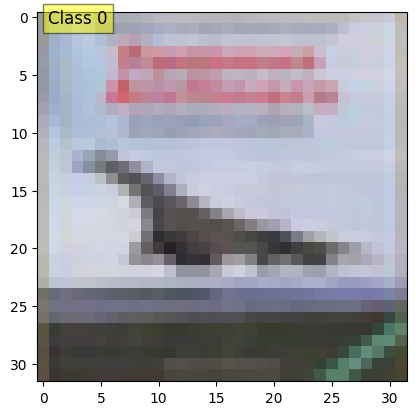

In [14]:
def visualize_predictions(image, bbox_pred, class_pred, class_names):
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle((bbox_pred[0], bbox_pred[1]), bbox_pred[2] - bbox_pred[0], bbox_pred[3] - bbox_pred[1],
                                      fill=False, edgecolor='red', linewidth=2))
    plt.text(bbox_pred[0], bbox_pred[1], class_names[np.argmax(class_pred)], bbox=dict(facecolor='yellow', alpha=0.5),
             fontsize=12, color='black')
    plt.show()

# Example prediction
sample_image = x_test[0]
bbox_pred, class_pred = model.predict(np.expand_dims(sample_image, axis=0))
class_names = ['Class 0']  # Only one class
visualize_predictions(sample_image, bbox_pred[0], class_pred[0], class_names)
